In [68]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt

In [69]:
DATASET_PATH = './Dataset/Logos'

X = []

target_size = (100, 100)

for idx, file_name in enumerate(os.listdir(DATASET_PATH)):

    file = os.path.join(DATASET_PATH, file_name)

    img = tf.keras.preprocessing.image.load_img(file, color_mode='rgb', target_size=target_size)
    img = tf.keras.preprocessing.image.img_to_array(img)

    X.append(img)

    if idx > 500:
        break

In [70]:
X = np.array(X) / 255.

n_test = 10

X_train = X[n_test:]
X_test = X[:n_test]

In [71]:
image_size = X[0].shape
image_shape = image_size[0] * image_size[1] * image_size[2]

LR = 0.00006
EPOCHS = 30
BATCH_SIZE = 20

In [72]:
class ReparameterizationLayer(tf.keras.layers.Layer):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, z_mean, z_log_var):

        epsilon = tf.random.normal(shape= tf.shape(z_mean))

        mean = z_mean
        std = tf.exp(0.5 * z_log_var)

        return mean + std * epsilon
    

class VAE(tf.keras.Model):

    def __init__(self, input_shape, dim, **kwargs):
        super().__init__(**kwargs)

        hidden_dim = dim[0]
        latent_dim = dim[1]

        inputs = tf.keras.layers.Input(shape= input_shape, name='Input')
        x = tf.keras.layers.BatchNormalization()(inputs)
        x = tf.keras.layers.Dense(hidden_dim, activation='relu')(x)

        z_mean = tf.keras.layers.Dense(latent_dim, name='Z_mean')(x)
        z_log_var = tf.keras.layers.Dense(latent_dim, name='Z_log_var')(x)
        z_out = ReparameterizationLayer(name='Reparameterization')(z_mean, z_log_var)
        self.encoder = tf.keras.models.Model(inputs, [z_out, z_mean, z_log_var], name='Encoder')

        # ----------------------------------------------------------

        x = tf.keras.layers.Dense(hidden_dim)(z_out)
        x = tf.keras.layers.Dense(image_shape)(x)

        outputs = tf.keras.layers.BatchNormalization()(x)

        self.decoder = tf.keras.models.Model(z_out, outputs, name='Decoder')

        self.full_model = tf.keras.models.Model(inputs, outputs, name='VAE')

    def call(self, inputs):

        z_out, z_mean, z_log_var = self.encoder(inputs)

        # print(f'Z: {z_out} | mean: {z_mean} | log_var: {z_log_var}')

        outputs = self.decoder(z_out)

        return outputs, z_out, z_mean, z_log_var
    


In [73]:
from tensorflow.keras.utils import plot_model

hidden_dim = 512
latent_dim = 32

model = VAE(image_shape, [hidden_dim, latent_dim])
model.build(input_shape=(BATCH_SIZE, image_shape))

# plot_model(vae.full_model, to_file='plot.png', show_shapes=True, show_layer_names=True)

In [74]:
model_plot = model.full_model

print(model_plot.summary())

Model: "VAE"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 30000)]              0         []                            
                                                                                                  
 batch_normalization_14 (Ba  (None, 30000)                120000    ['Input[0][0]']               
 tchNormalization)                                                                                
                                                                                                  
 dense_21 (Dense)            (None, 512)                  1536051   ['batch_normalization_14[0][0]
                                                          2         ']                            
                                                                                                

In [75]:
optimizer = tf.keras.optimizers.Adam(learning_rate= LR)

dataset = tf.data.Dataset.from_tensor_slices(X_train)
dataset = dataset.shuffle(BATCH_SIZE * 5).batch(batch_size= BATCH_SIZE)

In [76]:
def compute_loss(x):

    outputs, z_out, z_mean, z_log_var = model(x)

    batch_reconstruction_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels= x, logits= outputs)
    row_reconstruction_loss = batch_reconstruction_loss / BATCH_SIZE # Average per data in each batch
    reconstruction_loss = tf.reduce_sum(row_reconstruction_loss) # Calculate average of all data in batch

    mean_squared = tf.square(z_mean)
    var = tf.exp(z_log_var)

    kl_div = -0.5 * tf.reduce_sum(1 + z_log_var - mean_squared - var, axis= -1)
    kl_div = tf.reduce_mean(kl_div)

    loss = tf.reduce_mean(reconstruction_loss + kl_div)
    
    return loss, reconstruction_loss, kl_div


In [77]:
loss_history = []
kl_dv_history = []

num_batches = X_train.shape[0] // BATCH_SIZE

for idx, epoch in enumerate(range(EPOCHS)):

    for x in dataset:

        x = np.reshape(x, (-1, image_shape))

        with tf.GradientTape() as tape:

            loss, reconstruction_loss, kl_div = compute_loss(x)
        
        gradients = tape.gradient(loss, model.trainable_variables)

        for gradient in gradients:

            tf.clip_by_norm(gradient, 15)
        
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    
    loss_history.append(loss)
    kl_dv_history.append(kl_div)

    print(f'Epoch: [{idx + 1}/{EPOCHS}] Latest Batch Loss -> Reconstrution Loss: {reconstruction_loss:.2f} | KL Div: {kl_div:.2f} | Total: {loss:.2f}')


Epoch: [1/30] Latest Batch Loss -> Reconstrution Loss: 8203.36 | KL Div: 419.28 | Total: 8622.64
Epoch: [2/30] Latest Batch Loss -> Reconstrution Loss: 5698.24 | KL Div: 667.47 | Total: 6365.71
Epoch: [3/30] Latest Batch Loss -> Reconstrution Loss: 5853.98 | KL Div: 1238.78 | Total: 7092.75
Epoch: [4/30] Latest Batch Loss -> Reconstrution Loss: 6360.73 | KL Div: 496.46 | Total: 6857.19
Epoch: [5/30] Latest Batch Loss -> Reconstrution Loss: 5526.29 | KL Div: 454.23 | Total: 5980.52
Epoch: [6/30] Latest Batch Loss -> Reconstrution Loss: 4079.66 | KL Div: 498.28 | Total: 4577.95
Epoch: [7/30] Latest Batch Loss -> Reconstrution Loss: 3785.44 | KL Div: 351.31 | Total: 4136.76
Epoch: [8/30] Latest Batch Loss -> Reconstrution Loss: 3230.99 | KL Div: 280.12 | Total: 3511.10
Epoch: [9/30] Latest Batch Loss -> Reconstrution Loss: 2784.67 | KL Div: 302.60 | Total: 3087.28
Epoch: [10/30] Latest Batch Loss -> Reconstrution Loss: 3714.68 | KL Div: 304.64 | Total: 4019.32
Epoch: [11/30] Latest Batch 

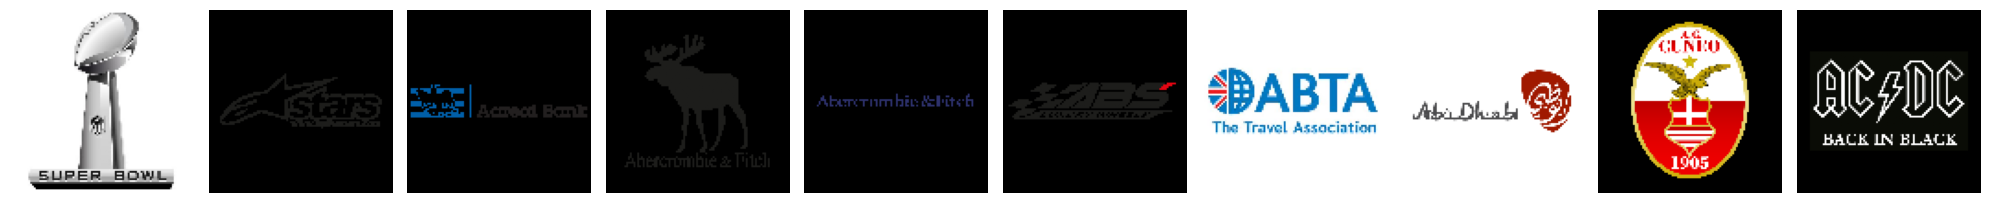

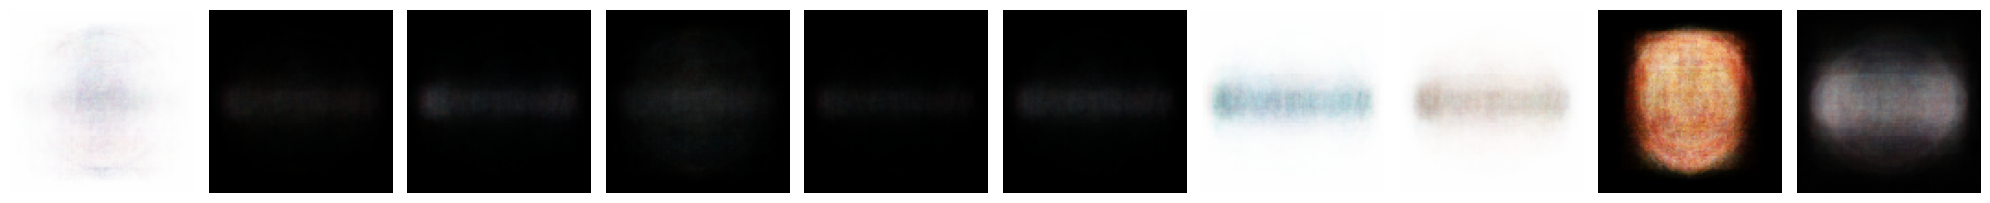

In [78]:
X_test = X_test.reshape(-1, image_shape)

outputs, _, _, _ = model(X_test)

outputs = tf.nn.sigmoid(outputs)

plt.figure(figsize=(20, 8))

for idx in range(n_test):

    ax = plt.subplot(2, n_test, idx + 1)
    
    img = X_test[idx]
    img = np.reshape(img, image_size)

    plt.imshow(img, cmap='gray')
    plt.axis(False)

plt.tight_layout()
plt.show()
    

plt.figure(figsize=(20, 8))

for idx in range(n_test):

    ax = plt.subplot(2, n_test, idx + 1)
    
    img = outputs[idx]
    img = np.reshape(img, image_size)

    plt.imshow(img, cmap='gray')
    plt.axis(False)

plt.tight_layout()
plt.show()
    